##Classifying mountains and icebergs##

As part of Lesson 1 of fast.ai [course](https://course.fast.ai/index.html) *Practical Deep Learning for Coders v3*, I used resnet34 to classify mountains and icebergs.

The main task was to create a customised dataset and train a classifier to distinguish between two objects. 

###Data preprocessing parts completed:###

*   Create personal image dataset using [Google Images](https://www.google.com/imghp?hl=en),
*   Install [Fatkun Batch](https://chrome.google.com/webstore/detail/fatkun-batch-download-ima/nnjjahlikiabnchcpehcpkdeckfgnohf) Download Image extension (Google Chrome browser),
*   bash script to archive data,
*   Store files on Google drive.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
root_path = 'gdrive/My Drive/datasets/correct'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The dataset can be untarred using the following couple bash commands.

*Note:* The Google drive link shared is not downloaded by default.

In [0]:
%%bash
fileid="1bxSQap6kq7YgVVYfsGHwPG7kfWrqWpb0"
filename="Mountains_Iceberg_dataset.tar.gz"
curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=${fileid}" -s > /dev/null
curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=${fileid}" -s -o ${filename}
tar --warning=no-unknown-keyword -xzf Mountains_Iceberg_dataset.tar.gz

###Image recognition scripts used in the course notebooks.###

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
#batch size
bs = 64
#image size
sz = 224 
PATH = './Mountains_Iceberg_dataset/'

In [5]:
!ls

cookie	Mountains_Iceberg_dataset	  sample_data
gdrive	Mountains_Iceberg_dataset.tar.gz


In [6]:
classes = []
for d in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, d)) and not d.startswith('.'):
        classes.append(d) 
print ("There are ", len(classes), "classes:\n", classes)    

There are  3 classes:
 ['models', 'iceberg', 'mountains']


In [0]:
for c in classes:
    print ("Class:", c)
    verify_images(os.path.join(PATH, c), delete=True);

In [0]:
data  = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=sz, bs=bs, valid_pct=0.2).normalize(imagenet_stats)

In [9]:
print ("There are", len(data.train_ds), "training images and", len(data.valid_ds), "validation images." )

There are 160 training images and 40 validation images.


A small dataset containing 100 images was used on a CNN pre-trained model during 4 epochs.

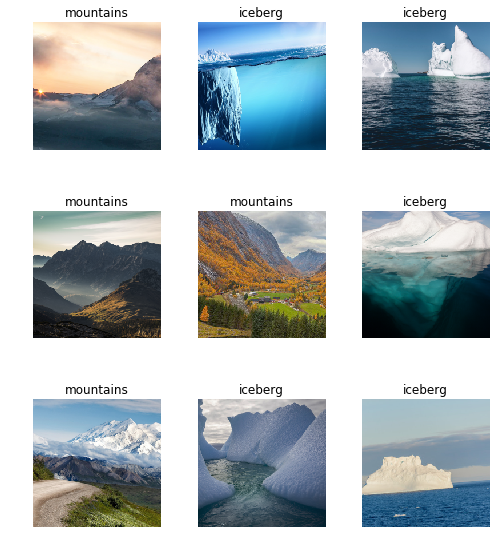

In [10]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.516803,1.526250,0.450000,00:26
1,1.014605,0.807603,0.300000,00:23
2,0.769455,0.526985,0.150000,00:24
3,0.605125,0.378449,0.100000,00:24


An **error rate** of **5%** was obtained.

In [0]:
learn.save('stage-1')

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

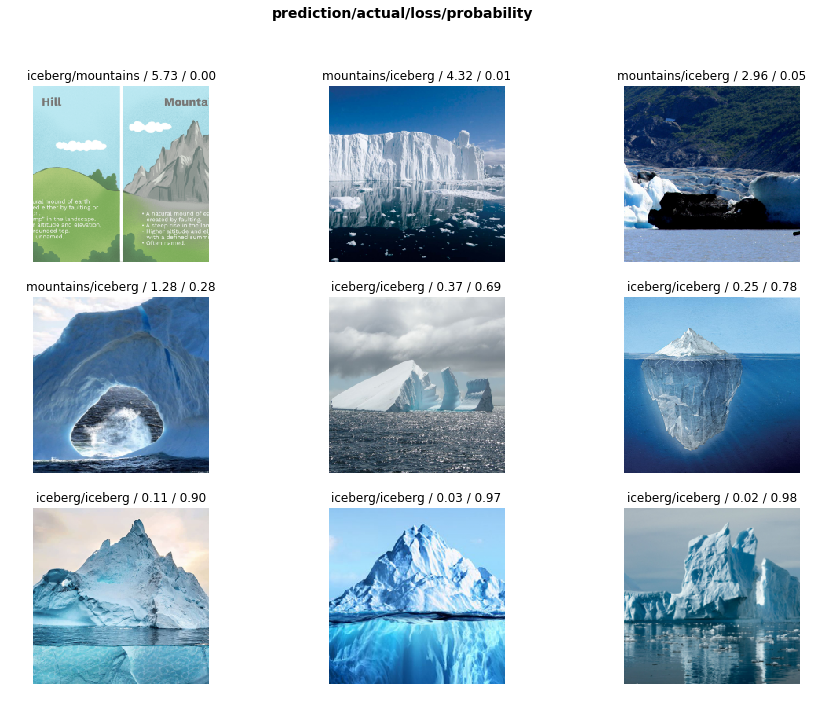

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

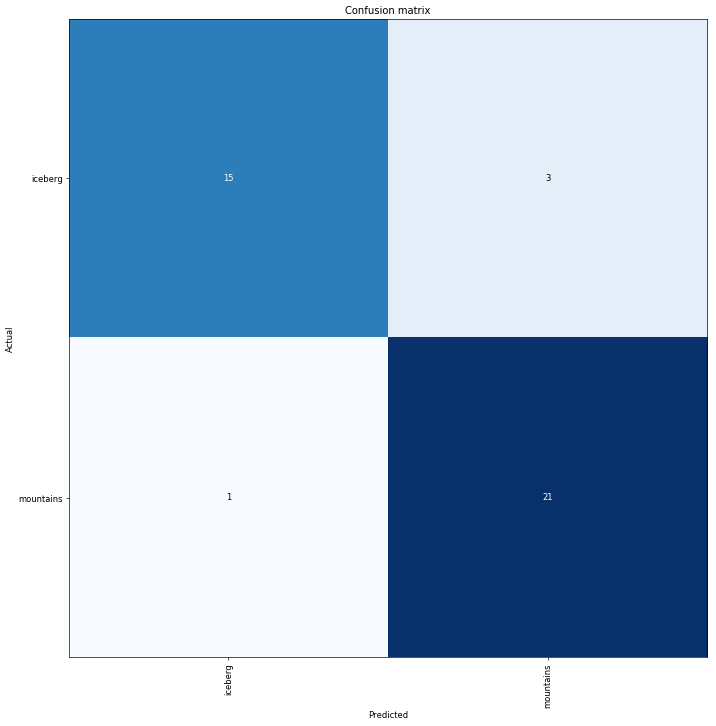

In [18]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

The confusion matrix shows that:


*   22 icebergs and 16 mountains are classified correctly,
*   1 example from each class is missclassified.



In [19]:
interp.most_confused(min_val=2)

[('iceberg', 'mountains', 3)]

In [0]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.154515,0.304456,0.050000,00:27


The **error rate** decreased to **2.5%**.


In [0]:
learn.load('stage-1');

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


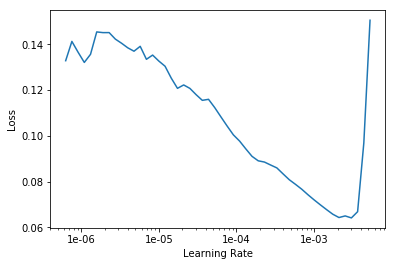

In [24]:
learn.recorder.plot()

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.133087,0.317617,0.100000,00:23
1,0.149155,0.284312,0.075000,00:26
